In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import gudhi
from pogo import Pogo
from scipy.sparse import csr_matrix
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from umap import UMAP,plot
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

from scipy.spatial.distance import is_valid_dm
import seaborn as sns#; sns.set_theme()


/home/a/Desktop/ds/env/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/a/Desktop/ds/env/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/a/Desktop/ds/env/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [2]:
pogo=Pogo()

In [3]:
hf = h5py.File('mouse_ES_cell.h5', 'r')
matrix = np.array(hf.get('X'))
ground_truth = np.array(hf.get('Y'))

In [4]:
hf = h5py.File('Quake_Smart-seq2_Diaphragm/data.h5', 'r')


In [5]:
exprs = hf.get('exprs')
np.array(exprs)

array(['data', 'indices', 'indptr', 'shape'], dtype='<U7')

In [6]:
obs = hf.get('obs')
np.array(obs)

array(['cell_ontology_class', 'cell_ontology_id', 'cell_type1', 'channel',
       'cluster', 'dataset_name', 'donor', 'free_annotation', 'gender',
       'organ', 'organism', 'platform', 'region'], dtype='<U19')

In [7]:
ground_truth = np.array(obs.get('cluster'))
ground_truth.shape

(870,)

In [8]:
uns = hf.get('uns')
np.array(uns)

array(['expressed_genes', 'scmap_genes', 'seurat_genes'], dtype='<U15')

In [9]:
data = np.array(exprs.get('data'))

In [10]:
num_rows = np.array(exprs.get('shape'))[0]
num_columns = np.array(exprs.get('shape'))[1]

In [11]:
print(num_rows)
print(num_columns)

870
23341


In [12]:
indices = np.array(exprs.get('indices'))

In [13]:
indptr = np.array(exprs.get('indptr'))

In [14]:
matrix = csr_matrix((data, indices, indptr), shape=(num_rows, num_columns)).toarray()

In [15]:
print(matrix.shape)
matrix

(870, 23341)


array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0., 101.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,  67.,   0., ...,   0.,   0.,   0.]])

In [16]:
cmdist = pdist(matrix, 'correlation')

In [17]:
cmdist.shape

(378015,)

In [18]:
mdist = squareform(cmdist, force='no', checks=True)

In [19]:
mdist.shape

(870, 870)

In [20]:
mdist

array([[0.        , 0.2481567 , 0.40205085, ..., 0.22494164, 0.23790942,
        0.22910211],
       [0.2481567 , 0.        , 0.11709152, ..., 0.14066171, 0.15410543,
        0.13934981],
       [0.40205085, 0.11709152, 0.        , ..., 0.33600546, 0.34593477,
        0.33774251],
       ...,
       [0.22494164, 0.14066171, 0.33600546, ..., 0.        , 0.06431486,
        0.06122598],
       [0.23790942, 0.15410543, 0.34593477, ..., 0.06431486, 0.        ,
        0.08066253],
       [0.22910211, 0.13934981, 0.33774251, ..., 0.06122598, 0.08066253,
        0.        ]])

In [21]:
is_valid_dm(mdist)

True

In [22]:
#Heatmap

#ax = sns.heatmap(mdist,cmap='Spectral')#, vmin=0, vmax=1, center=0.8)

#plt.title('Heatmap')
#plt.savefig('heatmap',dpi=100)

In [23]:
negmdist = np.negative(mdist)
similarity_matrix  = np.exp(negmdist)

CPU times: user 48 ms, sys: 98.9 ms, total: 147 ms
Wall time: 85.9 ms


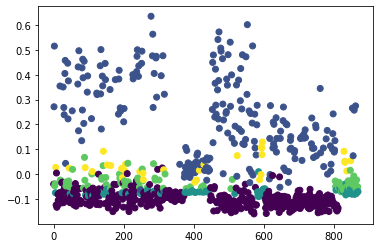

In [24]:
kpca_1d_model = KernelPCA(n_components=1, kernel='precomputed')
%time kpca1 = kpca_1d_model.fit_transform(similarity_matrix)
y = kpca1[:,0]
X = range(len(y))
plt.scatter(X,y,c=ground_truth)

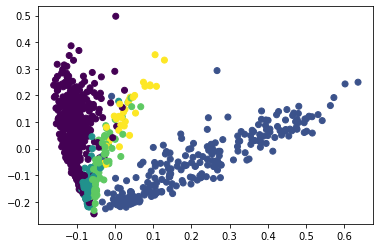

In [25]:

kpca_2d_model = KernelPCA(n_components=2, kernel='precomputed',random_state=42)
kpca2 = kpca_2d_model.fit_transform(similarity_matrix)
X = kpca2[:,0]
y = kpca2[:,1]
plt.scatter(X,y,c=ground_truth)

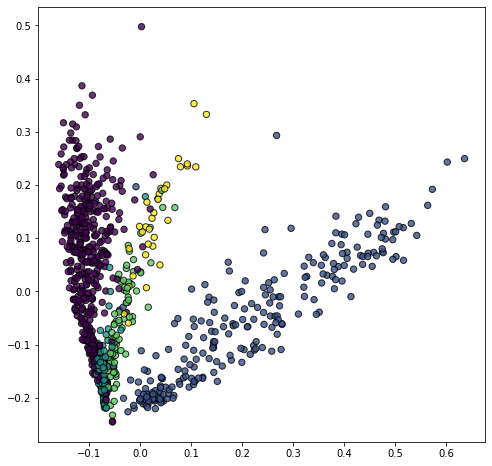

In [26]:

X = kpca2[:,0]
y = kpca2[:,1]
plt.figure(figsize=(8,8))
scatter = plt.scatter(X,y,
            s=40, 
            c=ground_truth,
            marker="o",
            #cmap=viridis,
            norm=None,
            alpha=.8,
            edgecolor="k",
            vmin = 0)

plt.show()

CPU times: user 51.7 ms, sys: 119 ms, total: 171 ms
Wall time: 65.3 ms


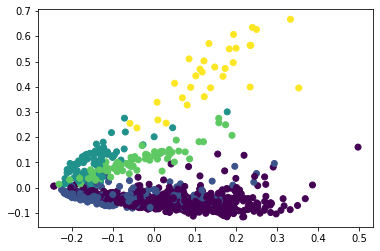

In [27]:
kpca_3d_model = KernelPCA(n_components=3, kernel='precomputed')
%time kpca3 = kpca_3d_model.fit_transform(similarity_matrix)
X = kpca3[:,1]
y = kpca3[:,2]
plt.scatter(X,y,c=ground_truth)

Text(0.5, 0.92, 'KPCA Embedding in 3D')

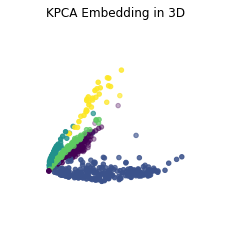

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(kpca3[:,0],kpca3[:,1],kpca3[:,2],c = ground_truth, cmap='viridis')
ax.set_axis_off()

#plt.legend(handles=scatter.legend_elements()[0],bbox_to_anchor=(1,1), labels=list(dict12.keys()))

plt.title('KPCA Embedding in 3D')
#plt.savefig('KPCA Embedding in 3D',dpi=100)

/home/a/Desktop/ds/env/lib/python3.8/site-packages/umap/umap_.py:1503: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


CPU times: user 9.25 s, sys: 283 ms, total: 9.53 s
Wall time: 8.01 s


Text(0.5, 1.0, 'Unlabeled UMAP Embedding in 2D')

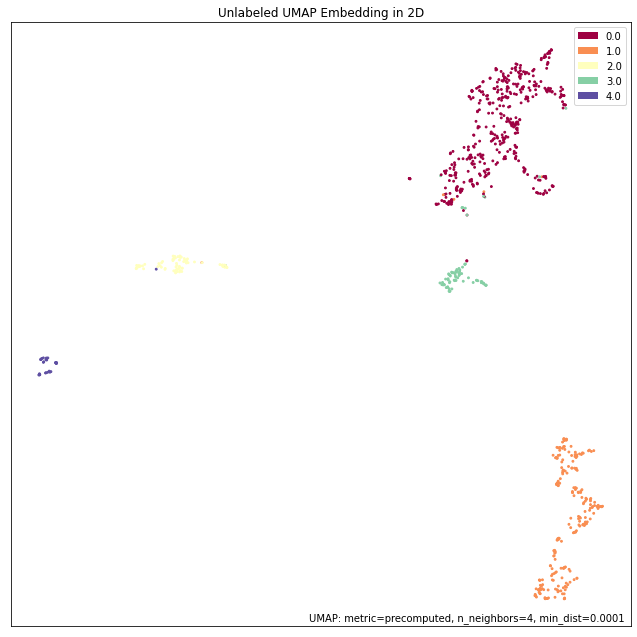

In [29]:
#Create 2-d umap dimensionality reduction embedding to visualize unsupervised models
umap_model_2d = UMAP(metric='precomputed',min_dist=0.0001,n_neighbors=4)
%time umap_embedding = umap_model_2d.fit_transform(mdist)
plot.points(umap_model_2d,labels=ground_truth)

plt.title('Unlabeled UMAP Embedding in 2D')

In [30]:
umap_embedding.shape

(870, 2)

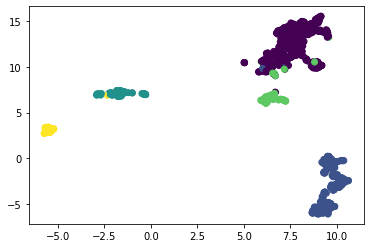

In [31]:
plt.scatter(umap_embedding[:,0], umap_embedding[:,1],c=ground_truth)

In [32]:
umap_model_33d = UMAP(metric='precomputed',min_dist=0.0001,n_neighbors=4,n_components=33)
umap_embedding_33d = umap_model_33d.fit_transform(mdist)

/home/a/Desktop/ds/env/lib/python3.8/site-packages/umap/umap_.py:1503: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


In [33]:
#run pogo on embeddings

In [99]:
kpca = KernelPCA(n_components=6, kernel='precomputed')
%time embedding = kpca.fit_transform(similarity_matrix)

CPU times: user 134 ms, sys: 116 ms, total: 250 ms
Wall time: 87.4 ms


In [149]:
umap= UMAP(metric='precomputed',min_dist=0.0001,n_neighbors=4,n_components=3)
%time embedding = umap.fit_transform(mdist)

/home/a/Desktop/ds/env/lib/python3.8/site-packages/umap/umap_.py:1503: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


CPU times: user 4.29 s, sys: 311 ms, total: 4.6 s
Wall time: 3.01 s


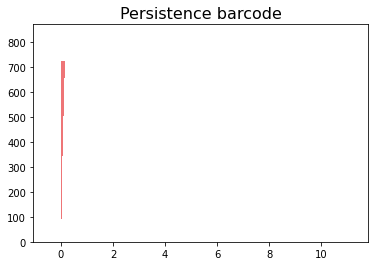

In [150]:
rips_complex = gudhi.RipsComplex(points=embedding)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)
diag = simplex_tree.persistence()

gudhi.plot_persistence_barcode(diag)
plt.show()

In [151]:
persistence_module = simplex_tree.persistence()

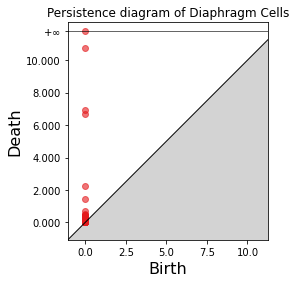

In [152]:
ax = gudhi.plot_persistence_diagram(persistence=persistence_module)
# We can modify the title, aspect, etc.
ax.set_title("Persistence diagram of Diaphragm Cells")
ax.set_aspect("equal")  # forces to be square shaped
plt.show()

In [153]:
%time pogo.fit(embedding)

CPU times: user 35.6 s, sys: 6.12 s, total: 41.7 s
Wall time: 35.3 s


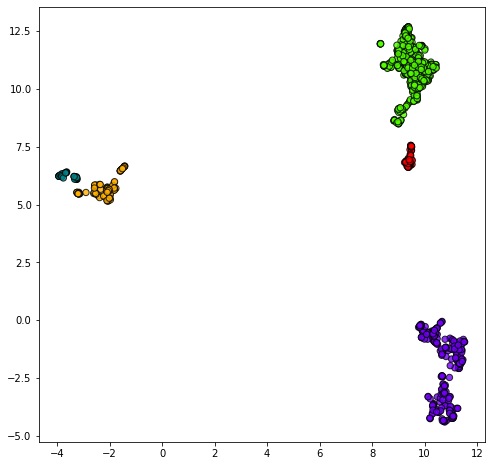

CPU times: user 228 ms, sys: 90.1 ms, total: 318 ms
Wall time: 186 ms


In [154]:
%time pogo.plot()

In [155]:
pogo.idx_

46317

In [156]:
pogo.candidates_

[74444,
 16689,
 46317,
 155121,
 9430,
 153076,
 8182,
 6845,
 6312,
 4261,
 4602,
 4852,
 7912,
 5973,
 5725,
 4027,
 3817,
 5378,
 5247,
 4507,
 5154,
 5630,
 4189,
 3583,
 3746,
 6244,
 3970,
 5094,
 5563,
 3652,
 5530,
 3721,
 3689,
 3799,
 3566,
 3709,
 3579,
 3704,
 7906,
 4183,
 3815,
 3707,
 5723,
 62832,
 62842,
 62819,
 62855,
 62859,
 62828,
 62837,
 62857,
 62843,
 62849,
 62846,
 62844,
 62829,
 62858,
 62821,
 62820,
 63232,
 62812,
 62831,
 62854,
 62845,
 62816,
 62852,
 62848,
 62847,
 62835,
 62853,
 62823,
 62836,
 62824,
 62860,
 62840,
 62815,
 62856,
 62825,
 62839,
 62851,
 62833,
 62834,
 62814,
 62817,
 62826,
 62813,
 62841,
 62822,
 63233,
 62830,
 62850,
 62818,
 62827,
 62838,
 63204,
 62811,
 62713,
 62720,
 62719,
 62718,
 62717,
 62716,
 62715,
 62714,
 62712,
 62704,
 62711,
 62710,
 62709,
 63239,
 62708,
 62707,
 62706,
 62721,
 62722,
 62723,
 62724,
 62739,
 62738,
 62737,
 62736,
 62735,
 62734,
 62733,
 62732,
 62731,
 62730,
 62729,
 62728,
 627

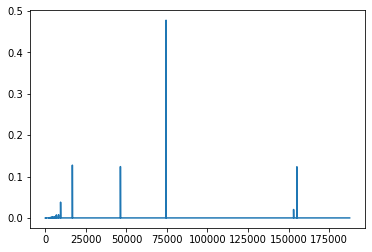

In [157]:
plt.plot(pogo.gap_vector_)

Maximum Silhouette: 46317


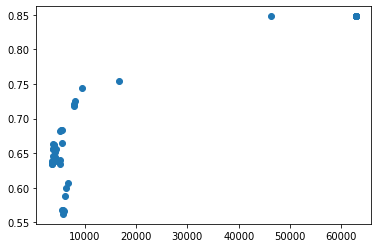

In [158]:
silhouette_indices, silhouette_array = pogo.plot_silhouette()

Maximum Silhouette Score: 46317


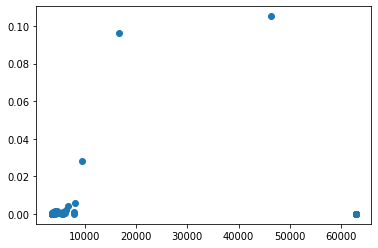

In [159]:
score_indices, score_array = pogo.plot_silhouette_score()

Maximum Rand Score: 46317


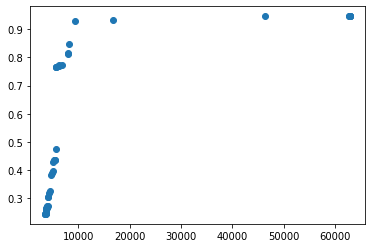

In [160]:
rand_indices, rand_array = pogo.plot_rand_score(ground_truth)


In [161]:
np.argmax(rand_array)

1

In [162]:
max(rand_array)

0.9466117161685742

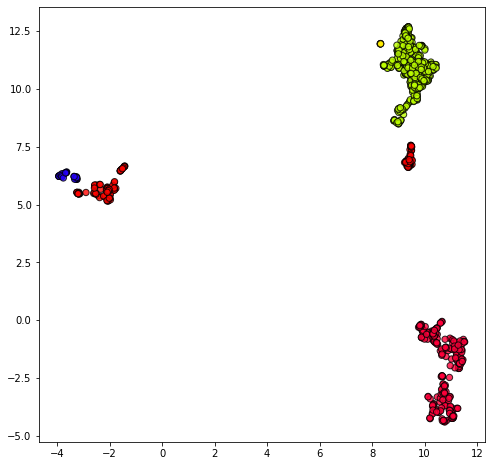

In [163]:
pogo.plot(26242)